# RHF 核坐标二阶 U 矩阵

这一节我们会讨论二阶 U 矩阵的计算。我们以前定义了一阶 U 矩阵 (Yamaguchi, p398, eq G.1)

$$
\frac{\partial}{\partial \mathbb{A}} C_{\mu p} = C_{\mu m} U_{mp}^\mathbb{A}
$$

而二阶 U 矩阵则定义为 (Yamaguchi, p398, eq G.2)

$$
\frac{\partial^2}{\partial \mathbb{A} \partial \mathbb{B}} C_{\mu p} = C_{\mu m} U_{mp}^\mathbb{AB}
$$

尽管二阶 U 矩阵的定义直截了当，但我们以后其实是不使用二阶 U 矩阵的。尽管如此，讨论二阶 U 矩阵的过程仍然是有意义的。

## 准备工作

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib, grad, hessian
from pyscf.scf import cphf
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff
from pyxdh.DerivOnce import GradSCF
from pyxdh.DerivTwice import HessSCF

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
gradh = GradSCF({"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12})
hessh = HessSCF({"deriv_A": gradh, "deriv_B": gradh})

In [4]:
nmo, nao, natm, nocc, nvir = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir
so, sv, sa = gradh.so, gradh.sv, gradh.sa
mol_slice = gradh.mol_slice
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo
H_1_ao, S_1_ao, eri1_ao, F_1_ao = gradh.H_1_ao, gradh.S_1_ao, gradh.eri1_ao, gradh.F_1_ao
H_1_mo, S_1_mo, eri1_mo, F_1_mo = gradh.H_1_mo, gradh.S_1_mo, gradh.eri1_mo, gradh.F_1_mo
Ax0_Core, B_1, U_1, U_1_vo = gradh.Ax0_Core, gradh.B_1, gradh.U_1, gradh.U_1_vo
H_2_ao, S_2_ao, eri2_ao = hessh.H_2_ao, hessh.S_2_ao, hessh.eri2_ao
H_2_mo, S_2_mo, eri2_mo = hessh.H_2_mo, hessh.S_2_mo, hessh.eri2_mo

In [5]:
def grad_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {"scf_eng": scf_eng, "cphf_tol": 1e-12}
    return GradSCF(config)

gradn = NucCoordDerivGenerator(mol, grad_generator)

In [6]:
def plot_diff(anal_mat, num_mat):
    fig, ax = plt.subplots(figsize=(2.4, 1.8)); ax.set_xscale("log")
    ax.hist(abs(anal_mat.ravel() - num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    ax.hist(abs(num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    return fig.tight_layout()

这一节中，我们所提及的 U 矩阵通常是未经“轨道旋转”的 (而非经过旋转的 $\mathscr{U}$)，它用 `U_1_nr` 表示。同时，使用了未经旋转的 $U_{pq}^\mathbb{A}$ 的计算实例 `gradh_nr`, `hessh_nr`：

In [7]:
gradh_nr = GradSCF({"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12, "rotation": False})
hessh_nr = HessSCF({"deriv_A": gradh_nr, "deriv_B": gradh_nr, "rotation": False})
U_1_nr = gradh_nr.U_1

In [8]:
def grad_nr_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {"scf_eng": scf_eng, "cphf_tol": 1e-12, "rotation": False}
    return GradSCF(config)

gradn_nr = NucCoordDerivGenerator(mol, grad_nr_generator)

但二阶 U 矩阵在以后我们就简单地用 `U_2` 表示了。在 pyxdh 中，并不存在专门用于计算二阶 U 矩阵的函数。

## 数值二阶 U 矩阵

由于二阶数值梯度的误差较大，我们应当将上面的二阶梯度求取方式尽量化为一阶数值导数。根据对 $C_{\mu p}$ 一阶导数的结果，我们容易知道

$$
\frac{\partial^2}{\partial \mathbb{A} \partial \mathbb{B}} C_{\mu p} = C_{\mu m} U_{mp}^\mathbb{AB} = C_{\mu m} \frac{\partial U_{mp}^\mathbb{A}}{\partial \mathbb{B}} + C_{\mu m} U_{mr}^\mathbb{B} U_{rp}^\mathbb{A}
$$

假使 $C_{\mu m}$ 矩阵可逆，同时我们更换一下角标，就得到 (Yamaguchi, p399, eq H.1)

$$
U_{pq}^\mathbb{AB} = \frac{\partial U_{pq}^\mathbb{A}}{\partial \mathbb{B}} + U_{pm}^\mathbb{B} U_{mq}^\mathbb{A}
$$

我们用 `n_U_2` 表示通过数值方法给出的 $U_{pq}^{A_t B_s}$：

In [9]:
nd_U_1 = NumericDiff(gradn_nr, lambda gradh_nr: gradh_nr.U_1).derivative.swapaxes(0, 1)
n_U_2 = nd_U_1 + np.einsum("Bpm, Amq -> ABpq", U_1_nr, U_1_nr)
n_U_2.shape

(12, 12, 22, 22)

## 解析二阶 U 矩阵

### Fock 矩阵二阶全导数

回顾到一阶 U 矩阵的计算，它的前提是未经过“轨道旋转”的 (Canonical) RHF 的 Fock 矩阵的非对角元为零。二阶 U 矩阵的推导也一样是这个前提。

我们先需要回顾一下 Fock 一阶梯度计算：

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = \big[ F_{pm} U_{mq}^\mathbb{A} + \mathrm{swap} (p, q) \big] + \frac{\partial F_{\mu \nu}}{\partial \mathbb{A}} C_{\mu p} C_{\nu q}
$$

上式有意地没有写成我们可以用于实际计算的表达式

$$
\frac{\partial F_{pq}}{\partial \mathbb{A}} = F_{pm} U_{mq}^\mathbb{A} + F_{qm} U_{mp}^\mathbb{A} + F_{pq}^\mathbb{A} + A_{pq, mk} U_{mk}^\mathbb{A}
$$

我们再作二阶导数，得到

$$
\begin{align}
\frac{\partial^2 F_{pq}}{\partial \mathbb{A} \partial \mathbb{B}}
&= \big[ F_{pr} U_{rm}^\mathbb{B} U_{mq}^\mathbb{A} + F_{rm} U_{rp}^\mathbb{B} U_{mq}^\mathbb{A} + \mathrm{swap} (p, q) \big] \\
&\quad + \big[ \frac{\partial F_{\mu \nu}}{\partial \mathbb{A}} C_{\mu m} U_{mp}^\mathbb{B} C_{\nu q} + \mathrm{swap} (p, q) + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big] \\
&\quad + \frac{\partial^2 F_{\mu \nu}}{\partial \mathbb{A} \partial \mathbb{B}} C_{\mu p} C_{\nu q} + \big[ F_{pm} \frac{\partial U_{mq}^\mathbb{A}}{\partial \mathbb{B}} + \mathrm{swap} (p, q) \big] \\
&= \big[ F_{pm} U_{mq}^{\mathbb{A} \mathbb{B}} + F_{rm} U_{rp}^\mathbb{B} U_{mq}^\mathbb{A} + \mathrm{swap} (p, q) \big] \\
&\quad + \big[ F_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + A_{pm, rk} U_{rk}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big] \\
&\quad + \frac{\partial^2 F_{\mu \nu}}{\partial \mathbb{A} \partial \mathbb{B}} C_{\mu p} C_{\nu q} \\
\end{align}
$$

上式中，$\partial_\mathbb{A} \partial_\mathbb{B} F_{\mu \nu}$ 还需要再进行进一步推导。


$$
\frac{\partial^2 F_{\mu \nu}}{\partial \mathbb{A} \partial \mathbb{B}} C_{\mu p} C_{\nu q} = \frac{\partial \big( F_{\mu \nu}^\mathbb{A} + A_{\mu \nu, \kappa \lambda} C_{\kappa m} U_{mk}^\mathbb{A} C_{\lambda k} \big)}{\partial \mathbb{B}} C_{\mu p} C_{\nu q}
$$

若我们定义 Fock Skeleton 导数 `F_2_ao` $F_{\mu \nu}^\mathbb{AB}$ 为

$$
\frac{\partial F_{\mu \nu}^\mathbb{A}}{\partial \mathbb{B}} = F_{\mu \nu}^\mathbb{AB} + \frac{\partial A_{\mu \nu, \kappa \lambda}}{\partial \mathbb{A}} C_{\kappa m} U_{mk}^\mathbb{B} C_{\lambda k}
$$

以及 A 张量全导数

$$
A_{\mu \nu, \kappa \lambda}^\mathbb{A} = \frac{\partial A_{\mu \nu, \kappa \lambda}}{\partial \mathbb{A}}
$$

那么，

$$
\frac{\partial^2 F_{\mu \nu}}{\partial \mathbb{A} \partial \mathbb{B}} C_{\mu p} C_{\nu q}
= F_{pq}^\mathbb{AB} + A_{pq, mk}^\mathbb{A} U_{mk}^\mathbb{B} + A_{pq, mk}^\mathbb{B} U_{mk}^\mathbb{A} + A_{pq, rk} U_{rm}^\mathbb{B} U_{mk}^\mathbb{A} + A_{pq, mr} U_{rk}^\mathbb{B} U_{mk}^\mathbb{A} + A_{pq, mk} U_{mk}^\mathbb{AB} - A_{pq, mk} U_{mr}^\mathbb{B} U_{rk}^\mathbb{A}
$$

综上，我们可以整理得到

$$
\begin{align}
\frac{\partial^2 F_{pq}}{\partial \mathbb{A} \partial \mathbb{B}}
&= F_{pq}^\mathbb{AB} + A_{pq, mk} U_{mk}^\mathbb{AB} + \varepsilon_p U_{pq}^\mathbb{AB} + \varepsilon_q U_{qp}^\mathbb{AB} \\
&\quad + \big[ F_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big] \\
&\quad + \varepsilon_m \big[ U_{mp}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) \big] \\
&\quad + A_{pq, mr} U_{mk}^\mathbb{A} U_{rk}^\mathbb{B} \\
&\quad + \big[ A_{pm, rk} U_{rk}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big] \\
&\quad + \big[ A_{pq, mk}^\mathbb{A} U_{mk}^\mathbb{B} + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big]
\end{align}
$$

### 重叠矩阵二阶全导数

在继续推导之前，我们引入二阶 U 矩阵的一个性质。我们考察重叠矩阵的全导数。在此之前，我们先回顾一下重叠矩阵一阶导数：

$$
\begin{align}
\frac{\partial S_{pq}}{\partial \mathbb{A}} = S_{pq}^\mathbb{A} + U_{pq}^\mathbb{A} + U_{qp}^\mathbb{A} = 0 
\end{align}
$$

相应地，我们可以给出

$$
\begin{align}
0 = \frac{\partial^2 S_{pq}}{\partial \mathbb{A} \partial \mathbb{B}}
&= S_{pq}^\mathbb{AB} + S_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + S_{mq}^\mathbb{A} U_{mp}^\mathbb{B} \\
&\quad + U_{pq}^\mathbb{AB} + U_{qp}^\mathbb{AB} - U_{pm}^\mathbb{B} U_{mq}^\mathbb{A} - U_{qm}^\mathbb{B} U_{mp}^\mathbb{A}
\end{align}
$$

我们会将上式中除了二阶 U 矩阵之外的项写为 `Xi_2` $\xi_{pq}^\mathbb{AB}$：(Yamaguchi, p405, eq L.4)

$$
\begin{align}
\xi_{pq}^\mathbb{AB}
&= S_{pq}^\mathbb{AB} + S_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + S_{mq}^\mathbb{A} U_{mp}^\mathbb{B} - U_{pm}^\mathbb{B} U_{mq}^\mathbb{A} - U_{qm}^\mathbb{B} U_{mp}^\mathbb{A} \\
&= \frac{1}{2} S_{pq}^\mathbb{AB} + U_{pm}^\mathbb{A} U_{qm}^\mathbb{B} - S_{pm}^\mathbb{A} S_{qm}^\mathbb{B} + \mathrm{swap} (\mathbb{A}, \mathbb{B})
\end{align}
$$

对于二阶核坐标梯度而言，代码可以写如：

In [10]:
Xi_2 = (
    + 0.5 * S_2_mo
    + np.einsum("Apm, Bqm -> ABpq", U_1_nr, U_1_nr)
    - np.einsum("Apm, Bqm -> ABpq", S_1_mo, S_1_mo)
)
Xi_2 += Xi_2.swapaxes(0, 1)

但需要注意到，现在我们讨论的是二阶核坐标梯度，因此被求导量 $\mathbb{A}, \mathbb{B}$ 是相同的，所以可以使用 `swapaxes` 求取。但若是像核坐标与电场混合二阶导数，就必须要显式地展开 $\mathrm{swap} (\mathbb{A}, \mathbb{B})$。

该量在 pyxdh 中也存在对应的 property：

In [11]:
np.allclose(Xi_2, hessh_nr.Xi_2)

True

<div class="alert alert-info">

**任务 (1)**

用程序证明，
    
$$
\xi_{pq}^\mathbb{AB} \neq S_{pq}^\mathbb{AB} + \mathscr{U}_{pm}^\mathbb{A} \mathscr{U}_{qm}^\mathbb{B} - S_{pm}^\mathbb{A} S_{qm}^\mathbb{B} + \mathrm{swap} (\mathbb{A}, \mathbb{B})
$$

这个结论几乎表明，尽管轨道旋转后的 $\mathscr{U}_{ai}^\mathbb{A}$ 可以与未旋转的 $U_{ai}^\mathbb{A}$ 设为相同，但在相同的轨道旋转构造下，$\mathscr{U}_{ai}^\mathbb{AB} \not\equiv U_{ai}^\mathbb{AB}$。

</div>

因此 (Yamaguchi, p405, eq L.3)

$$
\xi_{pq}^\mathbb{AB} + U_{pq}^\mathbb{AB} + U_{qp}^\mathbb{AB} = 0
$$

### 一阶 A 张量、Fock 二阶 Skeleton 导数与二阶 B 矩阵

我们利用上述的 $U_{pq}^\mathbb{AB}$ 与 $U_{qp}^\mathbb{AB}$ 之间的关系，重述 $\partial_\mathbb{A} \partial_\mathbb{B} F_{pq}$ 为：(Yamaguchi, p433, eq W.2)

$$
\begin{align}
\frac{\partial^2 F_{pq}}{\partial \mathbb{A} \partial \mathbb{B}}
&= (\varepsilon_p - \varepsilon_q) U_{pq}^\mathbb{AB} + A_{pq, bj} U_{bj}^\mathbb{AB} \\
&\quad + F_{pq}^\mathbb{AB} - \frac{1}{2} A_{pq, kl} \xi_{kl}^\mathbb{AB} - \xi_{pq}^\mathbb{AB} \varepsilon_q \\
&\quad + \big[ F_{pm}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big] \\
&\quad + \varepsilon_m \big[ U_{mp}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) \big] \\
&\quad + A_{pq, mr} U_{mk}^\mathbb{A} U_{rk}^\mathbb{B} \\
&\quad + \big[ A_{pm, rk} U_{rk}^\mathbb{A} U_{mq}^\mathbb{B} + \mathrm{swap} (p, q) + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big] \\
&\quad + \big[ A_{pq, mk}^\mathbb{A} U_{mk}^\mathbb{B} + \mathrm{swap} (\mathbb{A}, \mathbb{B}) \big]
\end{align}
$$

上式的第二行以后的所有项，我们定义为 `B_2` $B_{pq}^\mathbb{AB}$。在此之前，我们还是现将 $\mathrm{swap} (\mathbb{A}, \mathbb{B})$ 展开，避免以后的混合偏导数情况时重写代码：(Yamaguchi, p437, eq X.5)

$$
\begin{align}
B_{pq}^\mathbb{AB}
&= F_{pq}^\mathbb{AB} - \frac{1}{2} A_{pq, kl} \xi_{kl}^\mathbb{AB} - \xi_{pq}^\mathbb{AB} \varepsilon_q \\
&\quad + F_{mp}^\mathbb{A} U_{mq}^\mathbb{B} + F_{mp}^\mathbb{B} U_{mq}^\mathbb{A} + F_{mq}^\mathbb{A} U_{mp}^\mathbb{B} + F_{mq}^\mathbb{B} U_{mp}^\mathbb{A} \\
&\quad + ( U_{mp}^\mathbb{A} U_{mq}^\mathbb{B} + U_{mp}^\mathbb{B} U_{mq}^\mathbb{A} ) \varepsilon_m \\
&\quad + A_{pq, mr} U_{mk}^\mathbb{A} U_{rk}^\mathbb{B} \\
&\quad + A_{pm, rk} (U_{rk}^\mathbb{A} U_{mq}^\mathbb{B} + U_{rk}^\mathbb{B} U_{mq}^\mathbb{A}) \\
&\quad + A_{qm, rk} (U_{rk}^\mathbb{A} U_{mp}^\mathbb{B} + U_{rk}^\mathbb{B} U_{mp}^\mathbb{A}) \\
&\quad + A_{pq, mk}^\mathbb{A} U_{mk}^\mathbb{B} + A_{pq, mk}^\mathbb{B} U_{mk}^\mathbb{A}
\end{align}
$$

在给出二阶 B 矩阵之前，我们需要给出 `A_1_mo` $A_{pq, rs}^\mathbb{A}$ 的表达式：(Yamaguchi, p407, eq M.5)

$$
A_{pq, rs}^\mathbb{A} = C_{\mu p} C_{\nu q} \frac{\partial A_{\mu \nu, \kappa \lambda}}{\partial \mathbb{A}} C_{\kappa r} C_{\lambda s} = 4 (pq | rs)^\mathbb{AB} - (pr | qs)^\mathbb{AB} - (ps | qr)^\mathbb{AB}
$$

下述的代码并不是严格按上式来编写的，利用到了 ERI 积分的对称性。但需要指出，$A_{pq, rs}^\mathbb{A}$ 从推导的过程上，并不是 $A_{pq, rs}$ 的 Skeleton 导数。这点很关键，我们将会在 GGA 的 A 张量导数时作进一步说明。

In [12]:
A_1_mo = 4 * eri1_mo - eri1_mo.swapaxes(-1, -3) - eri1_mo.swapaxes(-2, -3)

在 pyxdh 中，具体执行 A 张量缩并的程序是 `Ax1_Core`，譬如对于 $A_{pq, rs}^\mathbb{A} X_{rs}$ 而言，

In [13]:
X = np.random.randn(nmo, nmo)
np.allclose(
    np.einsum("Apqrs, rs -> Apq", A_1_mo, X),
    gradh.Ax1_Core(sa, sa, sa, sa)(X)
)

True

除此之外，我们还需要给出 Fock 矩阵二阶 Skeleton 导数。需要留意的是，`F_2_ao` $F_{\mu \nu}^\mathbb{AB}$ 是由下式定义而来：

$$
\frac{\partial F_{\mu \nu}^\mathbb{A}}{\partial \mathbb{B}} = F_{\mu \nu}^\mathbb{AB} + \frac{\partial A_{\mu \nu, \kappa \lambda}}{\partial \mathbb{A}} C_{\kappa m} U_{mk}^\mathbb{B} C_{\lambda k}
$$

其在 RHF 下，表达式则为 (Yamaguchi, p408, M.7)

$$
F_{\mu \nu}^\mathbb{AB} = h_{\mu \nu}^\mathbb{AB} + (\mu \nu | \kappa \lambda)^\mathbb{AB} D_{\kappa \lambda} - \frac{1}{2} (\mu \kappa | \nu \lambda)^\mathbb{AB} D_{\kappa \lambda}
$$

In [14]:
F_2_ao = H_2_ao + ((eri2_ao - 0.5 * eri2_ao.swapaxes(-2, -3)) * D).sum(axis=(-1, -2))
F_2_mo = C.T @ F_2_ao @ C

我们仍然需要注意到，Fock 矩阵的 Skeleton 导数是由上式给出的。在 GGA 推导中，我们需要格外注意。

有这些准备后，我们就能给出二阶 B 矩阵 `B_2` 了：

上式的第二行以后的所有项，我们定义为 `B_2` $B_{pq}^\mathbb{AB}$。在此之前，我们还是现将 $\mathrm{swap} (\mathbb{A}, \mathbb{B})$ 展开，避免以后的混合偏导数情况时重写代码：(Yamaguchi, p437, eq X.5)

$$
\begin{align}
B_{pq}^\mathbb{AB}
&= F_{pq}^\mathbb{AB} - \frac{1}{2} A_{pq, kl} \xi_{kl}^\mathbb{AB} - \xi_{pq}^\mathbb{AB} \varepsilon_q \\
&\quad + F_{mp}^\mathbb{A} U_{mq}^\mathbb{B} + F_{mp}^\mathbb{B} U_{mq}^\mathbb{A} + F_{mq}^\mathbb{A} U_{mp}^\mathbb{B} + F_{mq}^\mathbb{B} U_{mp}^\mathbb{A} \\
&\quad + ( U_{mp}^\mathbb{A} U_{mq}^\mathbb{B} + U_{mp}^\mathbb{B} U_{mq}^\mathbb{A} ) \varepsilon_m \\
&\quad + A_{pq, mr} U_{mk}^\mathbb{A} U_{rk}^\mathbb{B} \\
&\quad + A_{pm, rk} (U_{rk}^\mathbb{A} U_{mq}^\mathbb{B} + U_{rk}^\mathbb{B} U_{mq}^\mathbb{A}) \\
&\quad + A_{qm, rk} (U_{rk}^\mathbb{A} U_{mp}^\mathbb{B} + U_{rk}^\mathbb{B} U_{mp}^\mathbb{A}) \\
&\quad + A_{pq, mk}^\mathbb{A} U_{mk}^\mathbb{B} + A_{pq, mk}^\mathbb{B} U_{mk}^\mathbb{A}
\end{align}
$$

In [15]:
B_2 = (
    # Line 1
    + F_2_mo
    - 0.5 * Ax0_Core(sa, sa, so, so)(Xi_2[:, :, so, so])
    - Xi_2 * e
    # Line 2
    + np.einsum("Amp, Bmq -> ABpq", F_1_mo, U_1_nr)
    + np.einsum("Bmp, Amq -> ABpq", F_1_mo, U_1_nr)
    + np.einsum("Amq, Bmp -> ABpq", F_1_mo, U_1_nr)
    + np.einsum("Bmq, Amp -> ABpq", F_1_mo, U_1_nr)
    # Line 3
    + np.einsum("Amp, Bmq, m -> ABpq", U_1_nr, U_1_nr, e)
    + np.einsum("Bmp, Amq, m -> ABpq", U_1_nr, U_1_nr, e)
    # Line 4
    + Ax0_Core(sa, sa, sa, sa)(np.einsum("Amk, Brk -> ABmr", U_1_nr[:, :, so], U_1_nr[:, :, so]))
    # Line 5
    + np.einsum("Apm, Bmq -> ABpq", Ax0_Core(sa, sa, sa, so)(U_1_nr[:, :, so]), U_1_nr)
    + np.einsum("Bpm, Amq -> ABpq", Ax0_Core(sa, sa, sa, so)(U_1_nr[:, :, so]), U_1_nr)
    # Line 6
    + np.einsum("Aqm, Bmp -> ABpq", Ax0_Core(sa, sa, sa, so)(U_1_nr[:, :, so]), U_1_nr)
    + np.einsum("Bqm, Amp -> ABpq", Ax0_Core(sa, sa, sa, so)(U_1_nr[:, :, so]), U_1_nr)
    # Line 7
    + np.einsum("Apqmk, Bmk -> ABpq", A_1_mo[:, :, :, :, so], U_1_nr[:, :, so])
    + np.einsum("Bpqmk, Amk -> ABpq", A_1_mo[:, :, :, :, so], U_1_nr[:, :, so])
)

In [16]:
np.allclose(B_2, hessh_nr.B_2)

True

### CP-HF 方程解二阶 U 矩阵

根据 $\partial_\mathbb{A} \partial_\mathbb{B} F_{ai}$ 的条件，我们能得到二阶 CP-HF 方程：

$$
- (\varepsilon_i - \varepsilon_a) U_{ai}^\mathbb{AB} - A_{ai, bj} U_{bj}^\mathbb{AB} = B_{ai}^\mathbb{AB}
$$

该式的求解过程与 CP-HF 方程求解一阶 U 矩阵、或者通过 Z-Vector 方法求 PT2+ 密度矩阵的方法完全相同。`U_2_nr_vo` 就可以用下述代码获得：

In [17]:
U_2_vo_nr = cphf.solve(
    Ax0_Core(sv, so, sv, so),
    e,
    gradh.scf_eng.mo_occ,
    B_2[:, :, sv, so].reshape(-1, nvir, nocc),
    max_cycle=100,
    tol=1e-12,
)[0].reshape(natm * 3, natm * 3, nvir, nocc)

就像一阶 U 矩阵的计算方式一样，剩余的部分是占据-占据与非占-非占部分。除了对角元之外，其余的项都可以用下述表达式给出：

$$
U_{pq}^\mathbb{AB} = - (B_{pq}^\mathbb{AB} + A_{pq, bj} U_{bj}^\mathbb{AB}) / (\varepsilon_p - \varepsilon_q), \quad p \neq q
$$

In [18]:
U_2_nr = - (B_2 + Ax0_Core(sa, sa, sv, so)(U_2_vo_nr)) / (e[:, None] - e[None, :])

而对角元是通过 $\xi_{pq}^\mathbb{AB} + U_{pq}^\mathbb{AB} + U_{qp}^\mathbb{AB} = 0$ 给出：

$$
U_{pp}^\mathbb{AB} = - \frac{1}{2} \xi_{pq}^\mathbb{AB}
$$

In [19]:
for p in range(nmo):
    U_2_nr[:, :, p, p] = - Xi_2[:, :, p, p] / 2

在 pyxdh 中，在给定 `rotation` 选项为 False 时，可以获得相同的 $U_{pq}^\mathbb{AB}$：

In [20]:
np.allclose(U_2_nr, hessh_nr.U_2)

True

我们也可以用数值方式给出的二阶 U 矩阵来验证我们的结果：

<IPython.core.display.Javascript object>


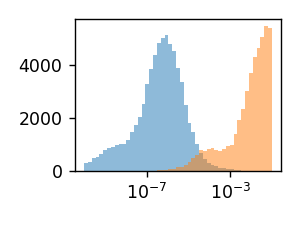

In [21]:
plot_diff(U_2_nr, n_U_2)

## 参考任务解答

### 任务 (1)

In [22]:
np.allclose(Xi_2, hessh.Xi_2)

False